In [7]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import cv2
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Expected file structure
"""
├── isr_wall
│   ├── images
│   │   ├── img_0001.jpg
            ...
│   │   └── img_0009.jpg
│   └── keypoints
│       ├── keypoints_0001.mat
            ...
│       └── keypoints_0009.mat
├── isr_wall.ipynb
""";

# 1. Visualizing the images

In [9]:
data_path = Path(os.getcwd()) / 'isr_wall'

# aerial_fpath = (data_path / './airport_CapeTown_aerial.png')
# first_frame_fpath = (data_path / './airport_CapeTown.png')

keypoints_fpaths = sorted((data_path / 'keypoints').glob('*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

images_fpaths = sorted((data_path / 'images').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

In [10]:
keypoints = [sp.io.loadmat(fpath)['kp'] for fpath in keypoints_fpaths]
descriptors = [sp.io.loadmat(fpath)['desc'] for fpath in keypoints_fpaths]
images = [np.array(Image.open(fpath)) for fpath in images_fpaths]

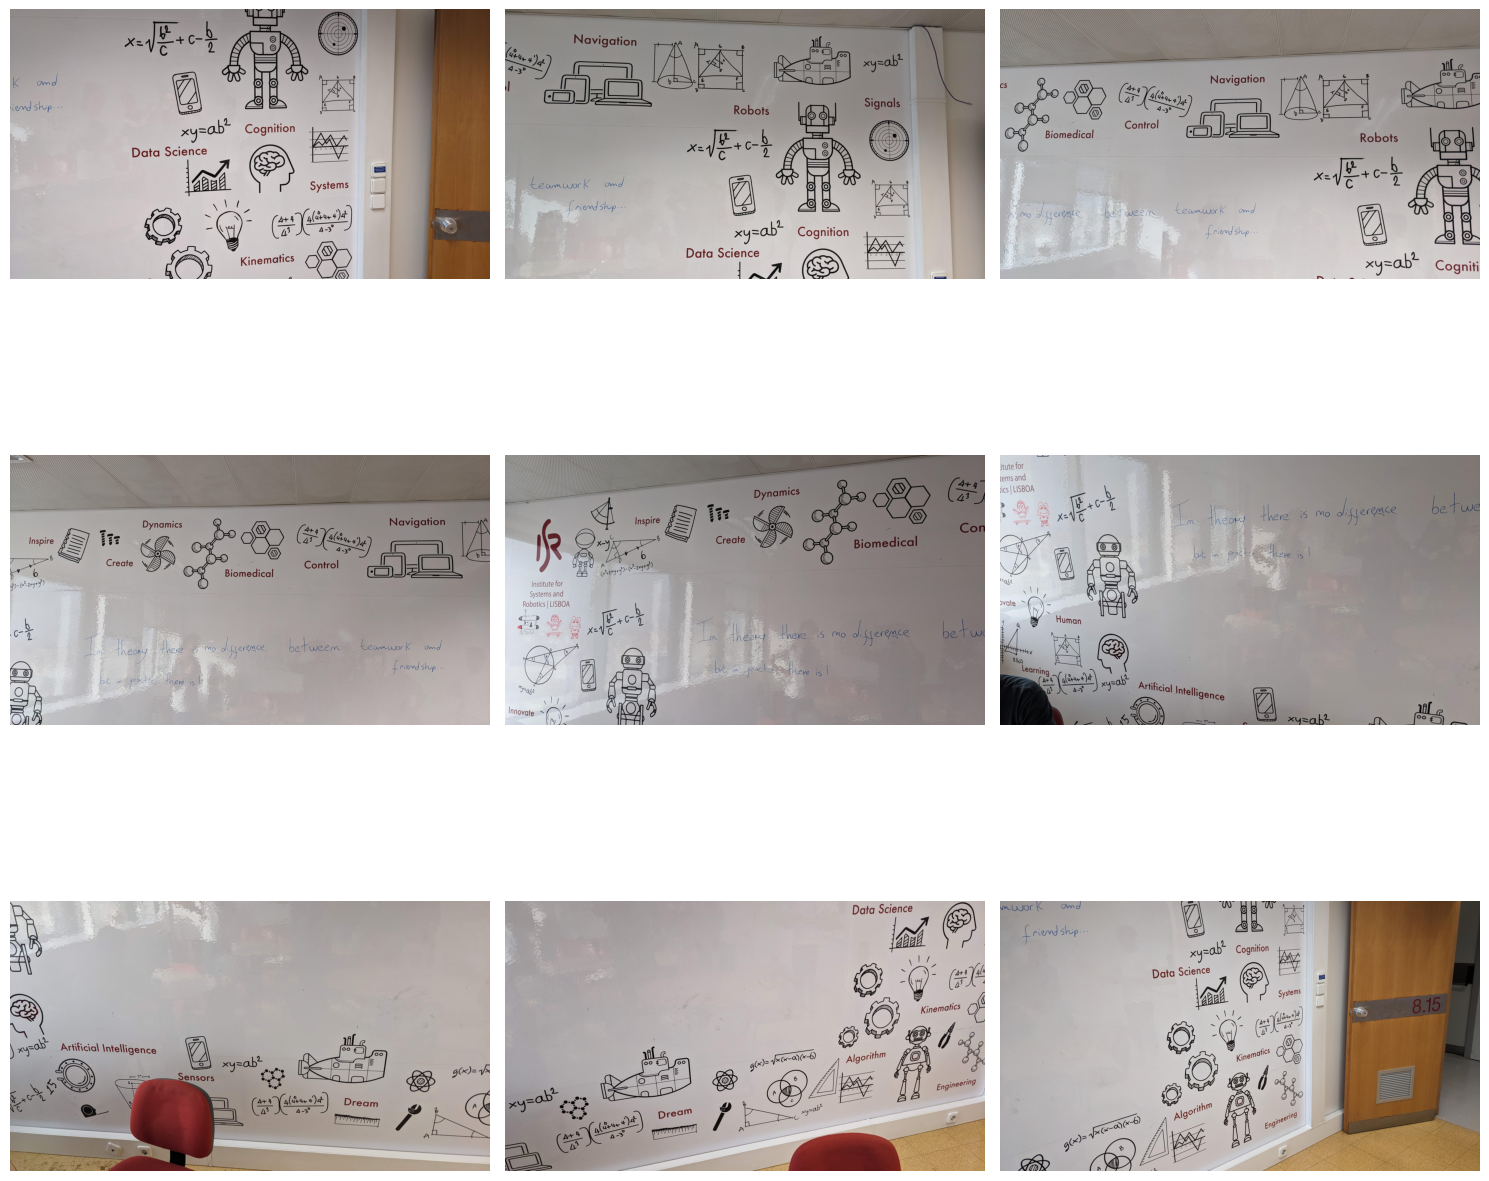

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, img, kp in zip(axes, images, keypoints):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

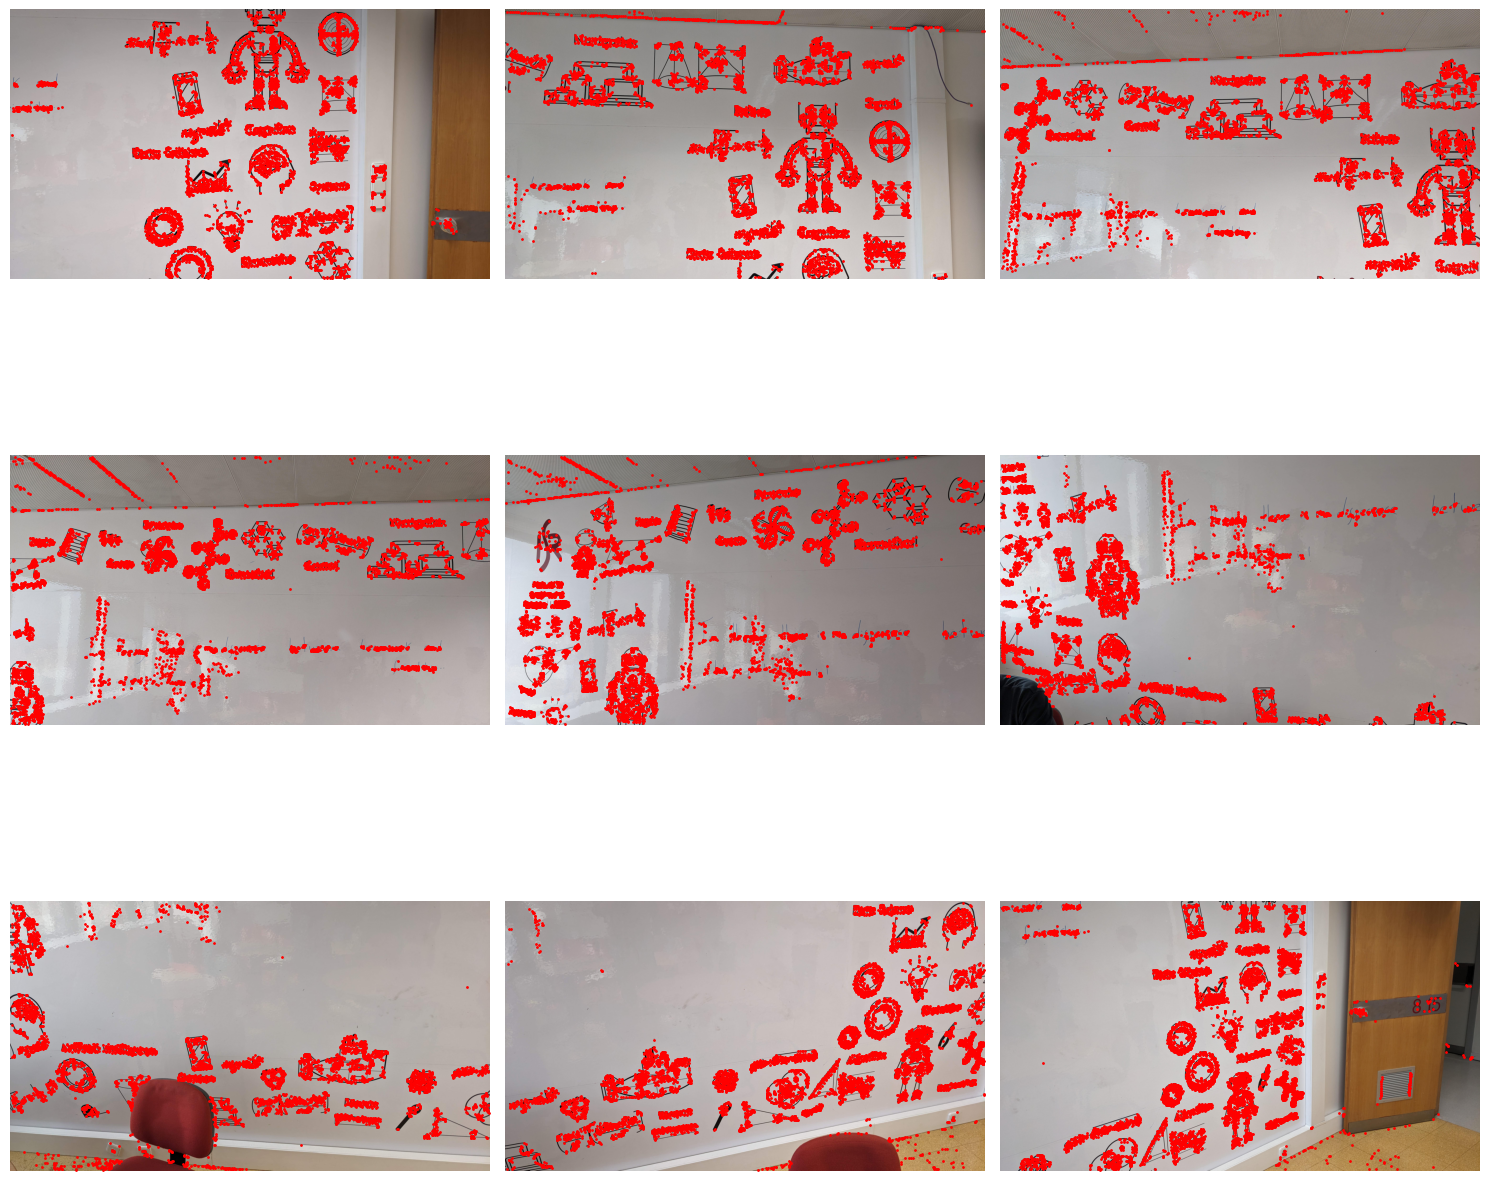

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, img, kp in zip(axes, images, keypoints):
    ax.imshow(img)
    ax.scatter(kp[:, 0], kp[:, 1], c='r', s=1)
    ax.axis('off')

plt.tight_layout()
plt.show()

# 2. Stitching two images

In [13]:
def convert_array_to_keypoints(keypoint_array):
    """Convert a NumPy array of (x, y) coordinates to a list of cv2.KeyPoint objects."""
    keypoints = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=1) for pt in keypoint_array]
    return keypoints
keypoints_cv = [convert_array_to_keypoints(kp) for kp in keypoints]

In [14]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors[0], descriptors[1])
matches = sorted(matches, key=lambda x: x.distance)

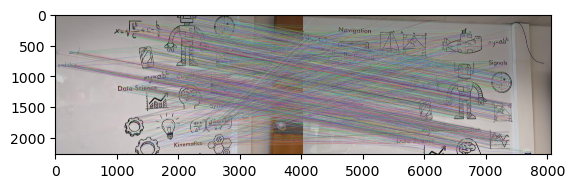

In [15]:
match_img = cv2.drawMatches(images[0], keypoints_cv[0], images[1], keypoints_cv[1], matches, None)
plt.imshow(match_img)

In [16]:
src_pts = np.array([keypoints_cv[0][m.queryIdx].pt for m in matches], dtype=np.float32)
dst_pts = np.array([keypoints_cv[1][m.trainIdx].pt for m in matches], dtype=np.float32)

In [17]:
# Step 5: Compute the homography using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


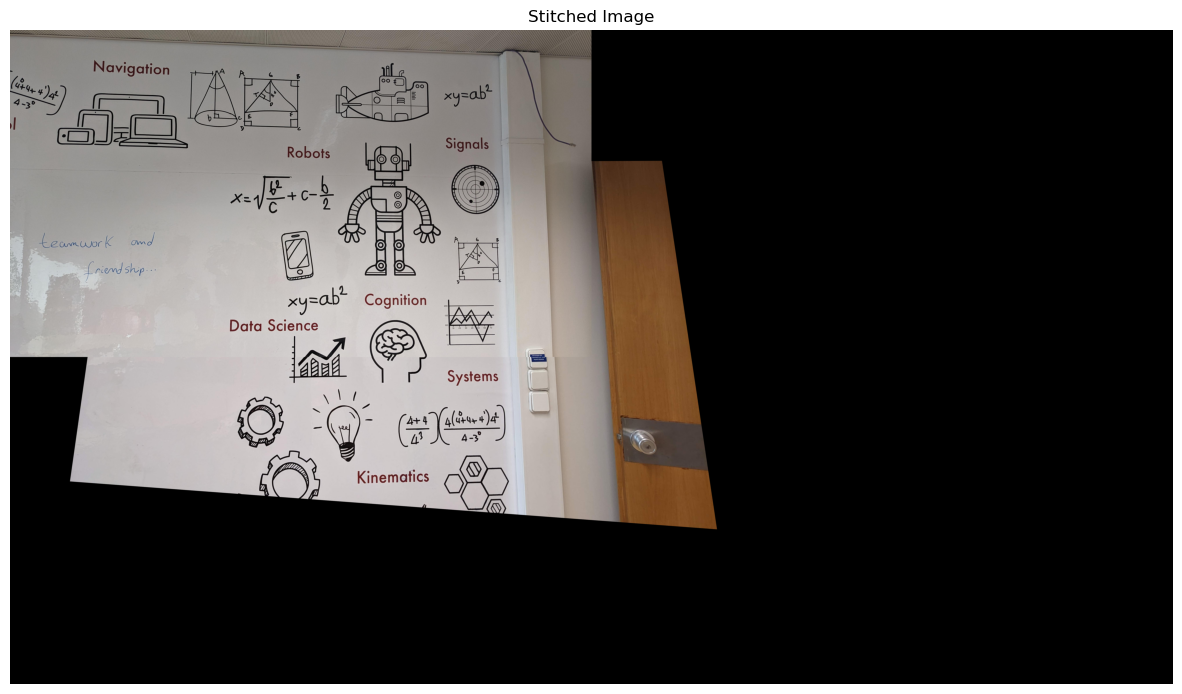

In [18]:
# Define canvas size (use a simple fixed size)
canvas_width = 2 * max(images[0].shape[1], images[1].shape[1])  # Double the width of the largest image
canvas_height = 2* max(images[0].shape[0], images[1].shape[0])  # Height of the tallest image

# Warp images[0] into the new canvas
warped_image1 = cv2.warpPerspective(images[0], H, (canvas_width, canvas_height))

# Paste images[1] into the canvas (at its correct position)
canvas = warped_image1.copy()
canvas[0:images[1].shape[0], 0:images[1].shape[1]] = images[1]

# Plot the stitched images
plt.figure(figsize=(15, 10))
plt.title('Stitched Image')
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.show()


# 3. Stiching all images

In [ ]:
def compute_matches_and_homographies(images, keypoints_cv, descriptors):
    """Match keypoints and compute homographies for each consecutive pair of images."""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    homographies = []
    all_matches = []

    for i in range(len(images) - 1):
        # Step 1: Match descriptors between image i and image i+1
        matches = bf.match(descriptors[i], descriptors[i + 1])
        matches = sorted(matches, key=lambda x: x.distance)

        # Step 2: Extract matching keypoints' coordinates
        src_pts = np.array([keypoints_cv[i][m.queryIdx].pt for m in matches], dtype=np.float32)
        dst_pts = np.array([keypoints_cv[i + 1][m.trainIdx].pt for m in matches], dtype=np.float32)

        # Step 3: Compute homography using RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        homographies.append(H)
        all_matches.append(matches)

    return homographies, all_matches


In [ ]:
homographies, all_matches = compute_matches_and_homographies(images, keypoints_cv, descriptors)


In [21]:
def stitch_images(images, homographies):
    """Stitch images together using homographies relative to the first image."""
    # Step 1: Calculate canvas size
    max_width = max([img.shape[1] for img in images])  
    max_height = max([img.shape[0] for img in images])  
    canvas_width = 6 * max_width  # 3x the largest image width
    canvas_height = 3 * max_height  # 3x the largest image height
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    
    # Step 2: Calculate the shift to place the first image in the center of the canvas
    shift_x = canvas_width // 2  # Shift the origin to the right
    shift_y = canvas_height // 3  # Shift the origin down
    
    # Step 3: Translation to center image[0] in the canvas
    translation_matrix = np.array([[1, 0, shift_x], 
                                   [0, 1, shift_y], 
                                   [0, 0, 1]], dtype=np.float32)

    
    # Step 4: Place the first image on the canvas
    current_H = translation_matrix  # Start with the shift for image[0]
    warped_image = cv2.warpPerspective(images[0], current_H, (canvas_width, canvas_height))
    mask = (warped_image > 0)  
    for c in range(3):  
        canvas[:, :, c][mask[:, :, c]] = warped_image[:, :, c][mask[:, :, c]]

    # Step 5: Stitch the rest of the images
    current_H = translation_matrix  # Start from the shifted position of image[0]
    
    for i in range(1, len(images)):
        # Invert the homography to align image[i] with image[0]
        H_inv = np.linalg.inv(homographies[i - 1])
        current_H = current_H @ H_inv  # Update cumulative homography relative to image[0]
        
        # Warp the current image using the cumulative homography
        warped_image = cv2.warpPerspective(images[i], current_H, (canvas_width, canvas_height))
        
        # Create a mask for non-black regions of the warped image
        mask = (warped_image > 0)  
        for c in range(3):  
            canvas[:, :, c][mask[:, :, c]] = warped_image[:, :, c][mask[:, :, c]]
        
    return canvas


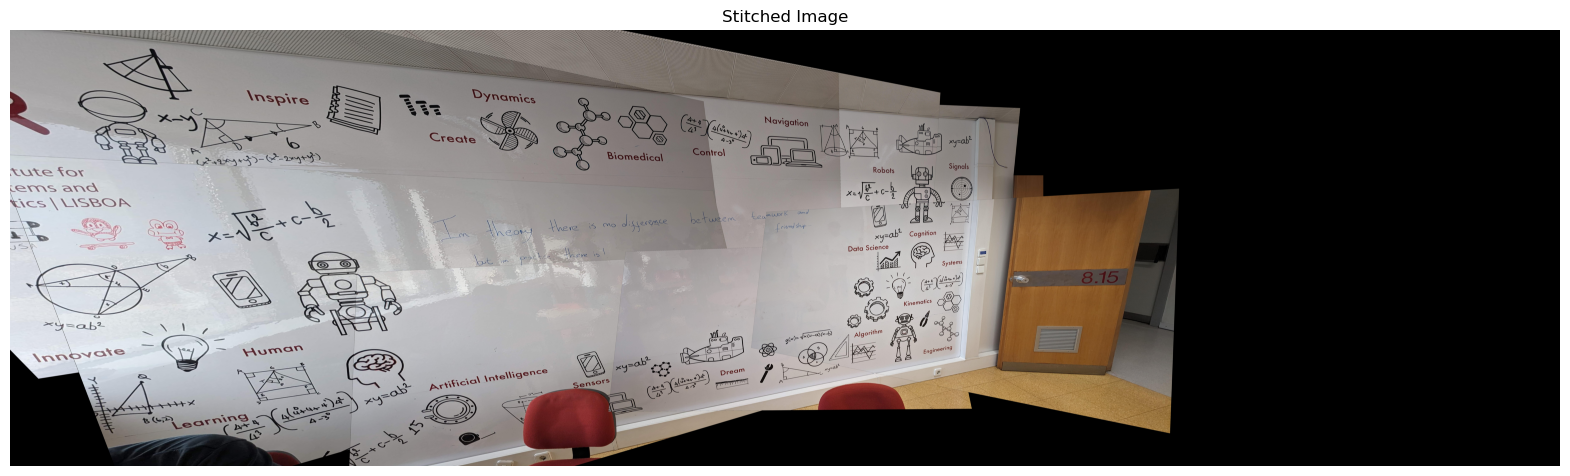

In [22]:
# Stitch all images together
stitched_image = stitch_images(images, homographies)

# Plot the stitched image
plt.figure(figsize=(20, 10))
plt.title('Stitched Image')
plt.imshow(stitched_image)
plt.axis('off')
plt.show()